<a href="https://colab.research.google.com/github/Womics/lab_rotation/blob/main/first_workat_labroat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **izhikevichでニューロンのモデルを作成**

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import pandas as pd

# Set random seed for reproducibility
np.random.seed(20000713)

# Define the IzhikevichNeuron class
class IzhikevichNeuron:
    def __init__(self, dt, a=0.02, b=0.2, c=-65, d=8):
        self.dt = dt
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.v_ = c  # Membrane potential as a scalar
        self.u_ = self.b * self.v_  # Recovery variable as a scalar
        self.firing_state = 0  # Firing state (0 or 1)

    def step(self, I):
        dv = (0.04 * self.v_**2 + 5 * self.v_ + 140 - self.u_ + I) * self.dt
        du = (self.a * (self.b * self.v_ - self.u_)) * self.dt
        self.v_ += dv
        self.u_ += du

        if self.v_ >= 30:
            self.firing_state = 1  # Set firing state
            self.v_ = self.c  # Reset membrane potential
            self.u_ += self.d  # Reset recovery variable
        else:
            self.firing_state = 0  # No firing

        return self.firing_state, self.v_

# Define the DelayConnection class
class DelayConnection:
    def __init__(self, N, delay, dt):
        self.N = N
        self.delay_step = max(1, int(round(delay / dt)))
        self.state = np.zeros((self.N, self.delay_step))

    def step(self, x):
        out = self.state[:, -1].copy()
        self.state[:, 1:] = self.state[:, :-1]
        self.state[:, 0] = x
        return out

# Constants
dt = 1  # Time step
T = 1000*60  # Total time (ms)
nt = round(T / dt)  # Number of simulation steps

# Number of neurons
n_neurons = 100
n_excitatory = int(n_neurons * 0.8)
n_inhibitory = int(n_neurons * 0.2)

# Excitatory neuron function
def Ex_Neuron():
    re = np.random.rand()
    return IzhikevichNeuron(dt=dt, a=0.02, b=0.2, c=-65 + 15 * (re**2), d=8 - 6 * (re**2))

# Inhibitory neuron function
def Inhib_Neuron():
    ri = np.random.rand()
    return IzhikevichNeuron(dt=dt, a=0.02 + 0.08 * ri, b=0.25 - 0.05 * ri, c=-65, d=2)

# Create neurons
neurons = [Ex_Neuron() for _ in range(n_excitatory)] + [Inhib_Neuron() for _ in range(n_inhibitory)]

# Create synaptic strength matrix S with max 10 outputs per neuron
"""
行 は 出力側（送信側）ニューロン を、列 は 入力側（受信側）ニューロン を表しています。

具体的には、S[i, j] の場合:

i 行: ニューロン i からの出力を示し、
j 列: ニューロン j への入力を示します。
したがって、S[i, j] は、ニューロン i からニューロン j への接続強度を示す値になります。
"""
S = np.zeros((n_neurons, n_neurons))
for i in range(n_neurons):
    connected_neurons = np.random.choice(n_neurons, 10, replace=False)
    S[i, connected_neurons] = 10 * np.random.rand(10)

# Set negative synaptic weights for inhibitory neurons
for i in range(n_excitatory, n_neurons):  # Inhibitory neurons start from n_excitatory
    S[i] = -np.abs(S[i])

# Ensure no self-connections by setting diagonal elements to 0
np.fill_diagonal(S, 0)

# Save the synaptic strength matrix S to a CSV file
S_df = pd.DataFrame(S, columns=[f'Neuron_{j}' for j in range(n_neurons)])
S_df.to_csv('synaptic_strength_matrix.csv', index_label='Neuron_Index')

# Initialize delay connections
delay = 5  # Set delay to 5 ms
delays = [DelayConnection(N=n_neurons, delay=delay, dt=dt) for _ in range(n_neurons)]

# Initialize membrane potential array
v_array = np.zeros((n_neurons, nt))
firing_array = np.zeros((n_neurons, nt))

# Track firing times and positions for plotting markers
firing_times = []
firing_positions = []

# Simulation loop
for t in tqdm(range(nt)):
    I_excitatory = 7.5 * np.random.rand(n_excitatory)
    I_inhibitory = 3 * np.random.rand(n_inhibitory)
    I = np.concatenate([I_excitatory, I_inhibitory])

    firing_states = np.zeros(n_neurons, dtype=int)
    membrane_potentials = np.zeros(n_neurons)

    for i in range(n_neurons):
        firing_states[i], membrane_potentials[i] = neurons[i].step(I[i])

    delayed_outputs = np.array([delays[i].step(firing_states[i]) for i in range(n_neurons)])
    inputs = S @ delayed_outputs + I

    v_array[:, t] = membrane_potentials
    firing_array[:, t] = firing_states

    if firing_states[0] == 1:
        firing_times.append(t * dt)
        firing_positions.append(membrane_potentials[0])

# Display the synaptic strength matrix
print("Synaptic Strength Matrix with Inhibitory Neurons Having Negative Weights (saved as 'synaptic_strength_matrix.csv'):")
print(S)


100%|██████████| 60000/60000 [02:57<00:00, 337.58it/s]

Synaptic Strength Matrix with Inhibitory Neurons Having Negative Weights (saved as 'synaptic_strength_matrix.csv'):
[[ 0.          3.99494997  0.         ...  0.          0.
   0.        ]
 [ 2.55016166  0.          0.         ...  0.          0.
   0.        ]
 [ 0.          0.          0.         ...  0.          4.47847475
   0.        ]
 ...
 [-0.         -0.         -0.         ...  0.         -0.
  -0.        ]
 [-0.         -1.03554425 -0.         ... -0.          0.
  -0.        ]
 [-0.         -0.         -3.48124624 ... -0.         -0.
   0.        ]]


In [ ]:
# Save firing data to CSV
firing_df = pd.DataFrame(firing_array, columns=[f'Time_{i*dt}ms' for i in range(nt)])

In [ ]:
firing_df.to_csv('neuron_firing_data_1min.csv', index_label='Neuron_Index')


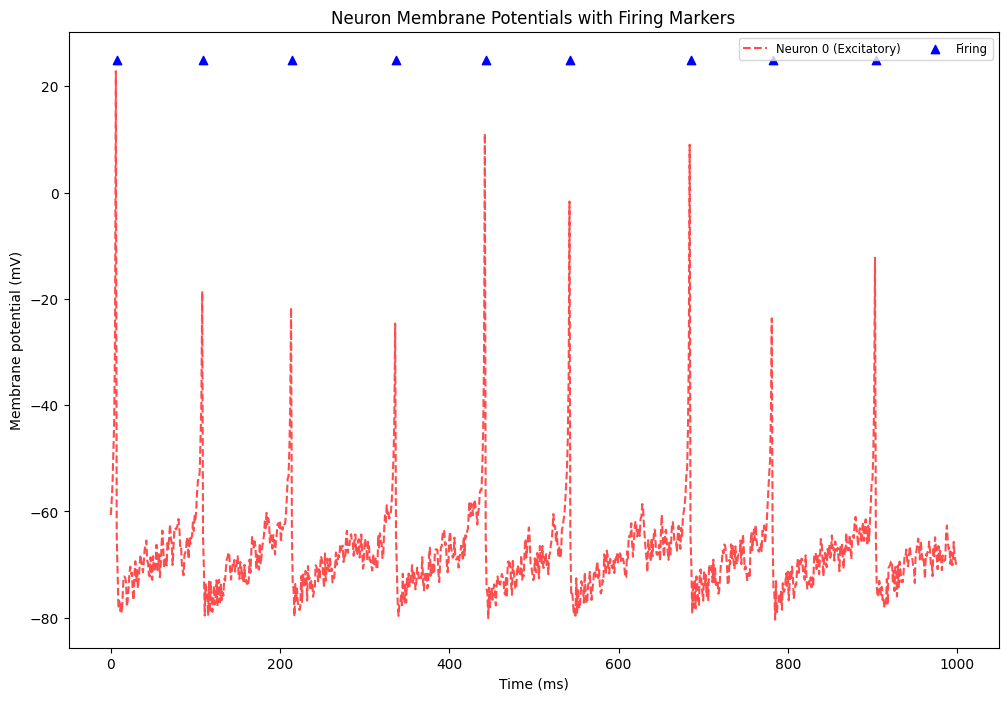

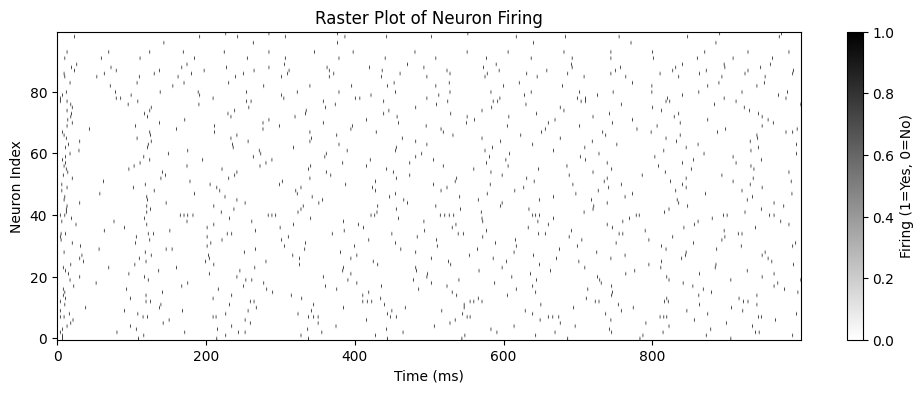

In [ ]:
# Define the first 10% of the simulation for plotting
plot_nt = int(nt)
plot_time = np.arange(plot_nt) * dt

# Plotting the membrane potentials with firing markers
plt.figure(figsize=(12, 8))
plt.plot(plot_time, v_array[0, :plot_nt], 'r--', label='Neuron 0 (Excitatory)', alpha=0.7)
plt.scatter(firing_times, np.array(firing_positions)*0+25, color='blue', marker='^', label='Firing', zorder=3)
plt.xlabel('Time (ms)')
plt.ylabel('Membrane potential (mV)')
plt.title('Neuron Membrane Potentials with Firing Markers')
plt.legend(loc='upper right', fontsize='small', ncol=2)
plt.show()

# Plotting the raster plot
plt.figure(figsize=(12, 4))
plt.imshow(firing_array[:, :int(nt)], aspect='auto', cmap='binary', origin='lower')
plt.xlabel('Time (ms)')
plt.ylabel('Neuron Index')
plt.title('Raster Plot of Neuron Firing')
plt.colorbar(label='Firing (1=Yes, 0=No)')
plt.show()


In [ ]:
import networkx as nx

# Define the number of neurons to select for visualization
num_neurons_to_select = 33

# Randomly select 33 neurons from the total number of neurons
selected_neurons = np.random.choice(n_neurons, num_neurons_to_select, replace=False)

# Create a subgraph based on the selected neurons
subgraph_matrix = S[selected_neurons, :][:, selected_neurons]

# Create a directed graph
G = nx.DiGraph()

# Add nodes to the graph
for neuron_id in selected_neurons:
    G.add_node(neuron_id, label=f"Neuron {neuron_id}")

# Add edges to the graph based on the subgraph matrix
for i, src in enumerate(selected_neurons):
    for j, dst in enumerate(selected_neurons):
        if subgraph_matrix[i, j] != 0:
            G.add_edge(src, dst, weight=subgraph_matrix[i, j])

# Define node shapes and colors for excitatory and inhibitory neurons
exc_nodes = [n for n in selected_neurons if n < n_excitatory]
inh_nodes = [n for n in selected_neurons if n >= n_excitatory]

# Define positions for circular layout
pos = nx.circular_layout(G)

# Plotting the graph
plt.figure(figsize=(12, 12))

# Draw excitatory neurons as red circles
nx.draw_networkx_nodes(G, pos, nodelist=exc_nodes, node_color='#ff9999', node_shape='o', node_size=500, label='Excitatory')

# Draw inhibitory neurons as blue squares
nx.draw_networkx_nodes(G, pos, nodelist=inh_nodes, node_color='#99ccff', node_shape='s', node_size=500, label='Inhibitory')

# Draw labels
nx.draw_networkx_labels(G, pos, labels={i: f"{i}" for i in selected_neurons}, font_size=10)

# Draw edges with varying thickness and color
for src, dst, data in G.edges(data=True):
    weight = abs(data['weight'])  # Absolute value of connection strength
    width = weight / 3  # Scale edge width
    if src < n_excitatory:  # Excitatory neuron
        nx.draw_networkx_edges(G, pos, edgelist=[(src, dst)], edge_color='red', width=width, arrows=True, arrowstyle='->', arrowsize=15)
    else:  # Inhibitory neuron
        nx.draw_networkx_edges(G, pos, edgelist=[(src, dst)], edge_color='blue', width=width, arrows=True, arrowstyle='->', arrowsize=15)

# Add a legend

plt.title("Directed Graph of 33 Selected Neurons with Variable Edge Widths")
plt.axis('off')
plt.show()


NameError: name 'n_neurons' is not defined

# **estimation function.c++をpythonで書き直した。**

In [ ]:
import numpy as np
from scipy.stats import norm



# Equivalent of ZeroOne in estimation function.C++
def ZeroOne(x):
    return 1 - x

# Equivalent of Pruning_cpp in C++
def Pruning_cpp(West, z):
    n = West.shape[1]
    for j in range(n):
        if z[j] == 1:
            West[:, j][West[:, j] < 0] = 0
        elif z[j] == 0:
            West[:, j][West[:, j] > 0] = 0
    return West

# Equivalent of EstimateConnections_cpp in C++
def EstimateConnections_cpp(Lambda, Eta, nitr):
    n = Lambda.shape[1]
    I = np.eye(n)
    Theta = np.random.rand(n, n)
    np.fill_diagonal(Theta, 0) #対角成分は0にしている

    for itr in range(nitr): #イテレーションは経験則で10くらいで収束する
      # step1
        West = Lambda @ (I - Theta)
        #step2
        for i in range(n):
            for j in range(n):
                Theta[i, j] = norm.cdf(West[i, j] + Eta[i, j])
        np.fill_diagonal(Theta, 0)
        #step3
        LT = Lambda @ Theta
        Lambda = Lambda - np.diag(np.diag(Lambda)) + np.diag(np.diag(LT))
    return West

# Displaying the defined functions to ensure they are correctly defined
EstimateConnections_cpp(np.array([[0.1, 0.3], [0.2, 0.4]]), np.array([[0.05, 0.07], [0.02, 0.06]]), 3)


array([[6.98463092e-19, 1.97102772e-01],
       [1.31401848e-01, 0.00000000e+00]])

In [ ]:
def EstimateConnectionsWithLabel_cpp(Lambda, Eta, z, nitr):
    n = Lambda.shape[1]
    I = np.eye(n)
    Theta = np.random.rand(n, n)
    np.fill_diagonal(Theta, 0)
    West = np.zeros((n, n))

    for _ in range(nitr):
        # Step 1
        West = Lambda @ (I - Theta)

        # Step 2
        West = Pruning_cpp(West, z)

        # Step 3
        for i in range(n):
            for j in range(n):
                Theta[i, j] = norm.cdf(West[i, j] + Eta[i, j])
        np.fill_diagonal(Theta, 0)

        # Step 4
        LT = Lambda @ Theta
        Lambda = Lambda - np.diag(np.diag(Lambda)) + np.diag(np.diag(LT))

    return West

import numpy as np
from scipy.stats import norm

def likelihood_cpp(Lambda, Eta, z, nitr):
    n = Lambda.shape[1]
    I = np.eye(n)
    Theta = np.zeros((n, n))
    West = EstimateConnectionsWithLabel_cpp(Lambda, Eta, z, nitr)

    for i in range(n):
        for j in range(n):
            Theta[i, j] = norm.cdf(West[i, j] + Eta[i, j])

    LT = Lambda @ Theta
    Lambda = Lambda - np.diag(np.diag(Lambda)) + np.diag(np.diag(LT))
    Error = Lambda - West @ np.linalg.inv(I - Theta)

    like = 1
    for i in range(n):
        for j in range(n):
            if Lambda[i, j] < 0:
                continue
            else:
                like *= norm.pdf(Error[i, j], 0, np.sqrt(0.15))

    return like

import numpy as np

def gibbs_cpp(Lambda, Eta, alpha, z, ind):
    z1 = z.copy()
    z0 = z.copy()
    z1[ind] = 1
    z0[ind] = 0

    like1 = likelihood_cpp(Lambda, Eta, z1, 10)
    like0 = likelihood_cpp(Lambda, Eta, z0, 10)
    fact1 = np.prod(np.power(alpha, z1) * np.power(1 - alpha, 1 - z1))
    fact0 = np.prod(np.power(alpha, z0) * np.power(1 - alpha, 1 - z0))

    # Adding a small value (epsilon) to the denominator to avoid division by zero
    epsilon = 1e-10  # You can adjust this value if needed
    prob = (like1 * fact1) / (like1 * fact1 + like0 * fact0 + epsilon)

    rand = np.random.uniform(0, 1)
    return 1 if rand < prob else 0

def remove_elem(x, idx):
    return np.delete(x, idx)

def sigmoid_cpp(x):
    return 1 / (1 + np.exp(-x))

def sample_z_cpp(n):
    return np.random.choice([0, 1], size=n, p=[0.5, 0.5])

def rbinom_cpp(n, beta):
    return np.random.binomial(1, beta, n)


In [ ]:
import numpy as np

def estimate_excitatory_probabilities_mproj_cpp(Lambda, Eta, States, nitr_em):
    n = Lambda.shape[1]
    nstate = States.shape[0]
    eps = 1e-5

    alpha = np.full(n, 0.5)
    beta = np.zeros(n)
    pre_alpha = alpha.copy()
    p = np.zeros(nstate)
    q = np.zeros(nstate)

    for itr in range(nitr_em):
        for i in range(nstate):
            state = States[i, :]
            like = likelihood_cpp(Lambda, Eta, state, 10)
            fact = np.prod(np.power(alpha, state) * np.power(1 - alpha, 1 - state))
            p[i] = like * fact
        p /= p.sum()

        for j in range(n):
            beta[j] = np.sum(States[:, j] * p)

        for i in range(nstate):
            state = States[i, :]
            q[i] = np.prod(np.power(beta, state) * np.power(1 - beta, 1 - state))

        for j in range(n):
            alpha[j] = np.sum(States[:, j] * q)

        vec_error = alpha - pre_alpha
        error = np.linalg.norm(vec_error)
        if error < eps:
            break
        else:
            pre_alpha = alpha.copy()

    return alpha


In [ ]:
import numpy as np
from scipy.stats import norm

def estimate_excitatory_probabilities_eproj_cpp(Lambda, Eta, States, nitr_em):
    n = Lambda.shape[1]
    nstate = States.shape[0]
    eps = 1e-16

    alpha = np.full(n, 0.5)
    beta = np.full(n, 0.5)
    pre_alpha = alpha.copy()
    C = np.zeros((nstate, n))

    for itr in range(nitr_em):
        for i in range(nstate):
            state = States[i, :]
            for j in range(n):
                estate = np.delete(state, j)
                ebeta = np.delete(beta, j)
                B = np.prod(np.power(ebeta, estate) * np.power(1 - ebeta, 1 - estate))
                z1 = state.copy()
                z0 = state.copy()
                z1[j] = 1
                z0[j] = 0
                like1 = likelihood_cpp(Lambda, Eta, z1, 5)
                like0 = likelihood_cpp(Lambda, Eta, z0, 5)
                fact1 = np.prod(np.power(alpha, z1) * np.power(1 - alpha, 1 - z1))
                fact0 = np.prod(np.power(alpha, z0) * np.power(1 - alpha, 1 - z0))
                A = np.log(like1 + fact1) - np.log(like0 + fact0)
                C[i, j] = B * A
        a = C.sum(axis=0)
        beta = sigmoid(a)

        # Update probabilities q
        q = np.array([np.prod(np.power(beta, States[i, :]) * np.power(1 - beta, 1 - States[i, :])) for i in range(nstate)])

        # Update alpha
        alpha = np.array([np.sum(States[:, j] * q) for j in range(n)])

        # Check convergence
        if np.linalg.norm(alpha - pre_alpha) < 1e-3:
            break
        pre_alpha = alpha.copy()

    return alpha


In [ ]:
def estimate_excitatory_probabilities_mproj_gibbs_cpp(Lambda, Eta, nitr_em, nsamp, excl_ratio):
    n = Lambda.shape[1]
    nexcl = int(round(nsamp * excl_ratio))
    ngibbs = nsamp - nexcl
    eps = 1e-4

    alpha = np.full(n, 0.5)
    pre_alpha = alpha.copy()
    Z1 = np.zeros((nsamp, n))

    for itr in range(nitr_em):
        if itr == 1:
            samp_z = sample_z_cpp(n)
        for i in range(nsamp):
            for j in range(n):
                samp_z[j] = gibbs_cpp(Lambda, Eta, alpha, samp_z, j)
            Z1[i, :] = samp_z.copy()

        subZ1 = Z1[nexcl:, :]
        beta = subZ1.mean(axis=0)

        for i in range(nsamp):
            samp_z = np.random.binomial(1, beta)
            Z2[i, :] = samp_z

        alpha = Z2.mean(axis=0)

        if np.linalg.norm(alpha - pre_alpha) < eps:
            break
        pre_alpha = alpha.copy()

    return alpha


In [ ]:
import numpy as np
from scipy.stats import norm, binom
from numpy.linalg import norm as np_norm

def estimate_excitatory_probabilities_eproj_gibbs_cpp(Lambda, Eta, nitr_em, nsamp, excl_ratio):
    """Estimates excitatory probabilities using a Gibbs sampler (e-projection)."""
    n = Lambda.shape[0]  # Assuming Lambda represents the connection matrix
    alpha = np.ones(n) * 0.5  # Initialize alpha with 0.5
    Z1 = np.zeros((nsamp, n))

    for _ in range(nitr_em):  # Main EM loop
        Z1 = np.zeros((nsamp, n))
        # Initialize samp_z here, outside the loop
        samp_z = np.zeros(n, dtype=int)
        for i in range(nsamp):  # Gibbs sampling loop
            for j in range(n):  # Iterate over neurons
                samp_z[j] = gibbs_cpp(Lambda, Eta, alpha, samp_z, j)
            Z1[i, :] = samp_z.copy()

        subZ1 = Z1[nexcl:, :]

        for i in range(ngibbs):
            state = subZ1[i, :]
            for j in range(n):
                estate = np.delete(state, j)
                ebeta = np.delete(beta, j)
                z1 = state.copy()
                z0 = state.copy()
                z1[j] = 1
                z0[j] = 0
                like1 = likelihood_cpp(Lambda, Eta, z1, 5)
                like0 = likelihood_cpp(Lambda, Eta, z0, 5)
                fact1 = np.prod(np.power(alpha, z1) * np.power(1 - alpha, 1 - z1))
                fact0 = np.prod(np.power(alpha, z0) * np.power(1 - alpha, 1 - z0))
                p1 = like1 * fact1
                p0 = like0 * fact0
                if p1 == 0:
                    p1 = eps
                if p0 == 0:
                    p0 = eps

                C[i, j] = np.log(p1) - np.log(p0)

        a = C.sum(axis=0) / ngibbs
        beta = 1 / (1 + np.exp(-a))

        for i in range(nsamp):
            samp_z = binom.rvs(1, beta)
            Z2[i, :] = samp_z

        alpha = Z2.mean(axis=0)

        vec_error = alpha - pre_alpha
        error = np_norm(vec_error)
        if error < 10:#1e-3:
            break
        pre_alpha = alpha.copy()

    return alpha


In [ ]:
!pip install scipy

# **estimating function.Rの内容をpythonに変換**


In [ ]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from scipy.special import erfinv

def calculate_pre_spike(data, pre_period, post_period):
    L = data.shape[1]  # observed time(列の数を吐く)
    if pre_period == 1:
        pre_spike = data.iloc[:, :L - post_period]
    else:
        pre_tmp = data.iloc[:, :L - post_period].T

        # Calculate convolution output size
        conv_output_size = pre_tmp.shape[0] - pre_period + 1

        pre_spike = np.convolve(pre_tmp.values.flatten(), np.ones(pre_period), mode='valid')

        # Reshape to the correct dimensions after convolution
        # The output of the convolution has shape (conv_output_size * data.shape[0],)
        # We need to reshape it to (conv_output_size, data.shape[0])

        # Calculate the number of elements that should be discarded
        discard_elements = pre_spike.shape[0] - (conv_output_size * data.shape[0])
        # Slice to remove those elements
        pre_spike = pre_spike[:-discard_elements]

        pre_spike = pre_spike.reshape(conv_output_size, data.shape[0])

        pre_spike[pre_spike > 0] = 1
        pre_spike = pd.DataFrame(pre_spike).T  # DataFrameに戻して転置
    return pre_spike

def calculate_post_spike(data, pre_period, post_period):
    L = data.shape[1]  # observed time
    if post_period == 1:
        # Use .iloc for DataFrame slicing
        post_spike = data.iloc[:, pre_period:L]
    else:
        # Use .iloc for DataFrame slicing
        post_tmp = data.iloc[:, pre_period:L].T
        post_spike = np.convolve(post_tmp.values.flatten(), np.ones(post_period), mode='valid').reshape(post_tmp.shape[0], -1) #Fixed a bug
        post_spike[post_spike > 0] = 1
        post_spike = post_spike.T
    return post_spike



def probit(p):
    return np.sqrt(2) * erfinv(2 * p - 1)

def calculate_spike_prob_matrix(pre_spike, post_spike, nclust):
    L = post_spike.shape[1]
    N = post_spike.shape[0]

    firing_sum = np.sum(pre_spike, axis=1)  # Assuming this sums across columns
    prob_fire = np.zeros((N, N))
    prob_rest = np.zeros((N, N))

    for i in range(N):
        for j in range(N):
            # Use .iloc to access rows and columns correctly
            Sj = pre_spike.iloc[i, :].values  # Get the values as a NumPy array
            Si = post_spike.iloc[j, :].values # Get the values as a NumPy array
            S_sum = Si + Sj
            S_dif = Si - Sj
            prob_fire[i, j] = np.sum(S_sum == 2) / firing_sum[i]
            prob_rest[i, j] = np.sum(S_dif == 1) / (L - firing_sum[i])

    prob_fire[prob_fire == 0] = np.finfo(float).eps
    prob_rest[prob_rest == 0] = np.finfo(float).eps

    array_prob = np.zeros((N, N, 2))
    array_prob[:, :, 0] = prob_fire
    array_prob[:, :, 1] = prob_rest

    return array_prob

def estimate_pseudo_connections(prob_fire, prob_rest):
    """Estimates pseudo connections by applying probit function along axis 1."""
    return np.apply_along_axis(probit, 1, prob_fire) - np.apply_along_axis(probit, 1, prob_rest)

def estimate_connections(Lambda, Eta, z, param):
    """Estimates connections using the specified parameters and method."""
    N = Lambda.shape[0]
    if z is None:
        West = estimate_connections_cpp(Lambda, Eta, param['number_of_iteration'])
    else:
        West = estimate_connections_with_label_cpp(Lambda, Eta, z, param['number_of_iteration'])
    return West

def estimate_excitatory_label_gibbs(Lambda, Eta, proj_type, param):
    """Estimates excitatory labels using a Gibbs sampler."""
    N = Lambda.shape[1]  # Use shape[1] as it represents the number of neurons
    nalpha = param['number_of_alpha']
    nsamp = param['number_of_Gibbs_sampler']
    excl_ratio = param['gibbs_exclude_ratio']

    Alphas = []
    if proj_type == 'e':
        for i in range(nalpha):
            alpha = estimate_excitatory_probabilities_eproj_gibbs_cpp(Lambda, Eta, param['number_of_EM_iteration'], nsamp, excl_ratio)
            Alphas.append(alpha)
    elif proj_type == 'm':
        for i in range(nalpha):
            alpha = estimate_excitatory_probabilities_mproj_gibbs_cpp(Lambda, Eta, param['number_of_EM_iteration'], nsamp, excl_ratio)
            Alphas.append(alpha)

    z = (np.mean(Alphas, axis=0) != 1).astype(int)
    return z

# **main.Rをpythonで書き直す**

In [ ]:
import pandas as pd
import numpy as np

# Set parameters
pre_period = 10
post_period = 1

params = {
    "excitatory_threshold": 0.5,
    "number_of_iteration": 10,
    "number_of_EM_iteration": 50,
    "number_of_cluster": 10,
    "number_of_alpha": 10,
    "number_of_Gibbs_sampler": 100,
    "gibbs_exclude_ratio": 0.02
}
filepath="neuron_firing_data_1min.csv"
print("Reading data...")
data = pd.read_csv(filepath)  # Assuming the data file is a pickle for Python compatibility
data.head()

Reading data...


,Neuron_Index,Time_0ms,Time_1ms,Time_2ms,Time_3ms,Time_4ms,Time_5ms,Time_6ms,Time_7ms,Time_8ms,...,Time_59990ms,Time_59991ms,Time_59992ms,Time_59993ms,Time_59994ms,Time_59995ms,Time_59996ms,Time_59997ms,Time_59998ms,Time_59999ms
0,0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
print("Preprocessing spikes...")
pre_spike = calculate_pre_spike(data.iloc[:,1:], pre_period, post_period)
post_spike = calculate_post_spike(data.iloc[:,1:], pre_period, post_period)

array_prob = calculate_spike_prob_matrix(pre_spike, post_spike, params['number_of_cluster'])
prob_fire = array_prob[:, :, 0]
prob_rest = array_prob[:, :, 1]
del pre_spike, post_spike  # free memory

Lambda = estimate_pseudo_connections(prob_fire, prob_rest)

# Change axis to 1 as prob_rest is 2-dimensional
Eta = np.apply_along_axis(probit, 1, prob_rest)
del prob_fire, prob_rest  # free memory



Preprocessing spikes...


In [ ]:
print("Estimating excitatory label...")
z = estimate_excitatory_label_gibbs(Lambda, Eta, "e", params)



Estimating excitatory label...


<ipython-input-6-bcc27de67ec1>:65: RuntimeWarning: invalid value encountered in scalar divide
  prob = (like1 * fact1) / (like1 * fact1 + like0 * fact0)


In [ ]:
print("Estimating neural connections...")
West = estimate_connections(Lambda, Eta, z, params)
print("-> done.")